# [Survival Analysis](https://en.wikipedia.org/wiki/Survival_analysis)

from : https://www.pymc.io/projects/examples/en/latest/survival_analysis/survival_analysis.html

## Theory

If the random variable $T$ is the time to the event we are studying, survival analysis is primarily concerned with the survival function: 
$$
S(t) = Pr(T > t) = 1 - F(t)
$$

Where $F(t)$ is the cumulative distribution function of $T$.

The survival function is the probability that the event will occur by time $t$ and is express in terms of [hazard rate](https://en.wikipedia.org/wiki/Survival_analysis#Hazard_function_and_cumulative_hazard_function), $\lambda(t)$, which is the instantaneous probability that the event will occur by time $t$ given that it has not already occurred by time $t$.

$$
\lambda(t) = \lim_{\Delta t \to 0} \frac{Pr(t < T > t + \Delta t | T > t)}{\Delta t}
$$

Which can be simplified to
$$
\lambda(t) = \frac{S'(t)}{S(t)}
$$

Solving this differential equation for the survival function shows that:

$$
S(t) =  exp(-\int_0^t \lambda(s) ds)
$$

This representation of the survival function shows that the cumulative hazard function is:

$$
\Lambda(t) = \int_0^t \lambda(s) ds
$$

An important, but subtle, point in survival analysis is [censoring](https://en.wikipedia.org/wiki/Survival_analysis#Censoring). 

## Bayesian proportional hazards model
Perhaps the most commonly used risk regression model is [Cox’s proportional hazards model(https://en.wikipedia.org/wiki/Proportional_hazards_model)]. In this model, if we have covariates $x$ and regression coefficients $\beta$, the hazard rate is modeled as :

$$
\lambda(t) = \lambda_0(t)exp(x\beta)
$$

Here $\lambda_0(t)$ is the baseline hazard rate which is independent of the covariates $x$.
In order to perform Bayesian inference with the Cox model, we must specify priors on $\beta$ and $\lambda_0(t)$:
$$\beta \sim N(\mu_\beta, \sigma^2_\beta)$$
$$\mu_\beta \sim Nomral(0, 10^2)$$ 
$$\sigma^2_\beta \sim Uniform(0,10)$$

$\lambda_0(t)$ is set as a semiparametric prior, a constant function, which require to partition the time range into intervals. This requires to choose priors for the $N-1$ intervals $\lambda_j$. $\lambda_j$ is usually a [Weibull distribution](https://en.wikipedia.org/wiki/Weibull_distribution) or a [Gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution).


The key observation is that the piecewise-constant proportional hazard model is closely related to a Poisson regression model. (The models are not identical, but their likelihoods differ by a factor that depends only on the observed data and not the parameters $\beta$ and $\lambda_j$.
We define indicator variables based on whether the $i$-th subject died in the $j$-th interval:

$$
d_{ij} = \begin{cases} 
1 & \text{if subject } i \text{ died in interval } j, \\
0 & \text{otherwise.}
\end{cases}
$$

We also define $t_{i,j}$ to be the amount of time the $i$-th subject was at risk in the $j$-th interval.


## Code

jax.local_device_count 32


sample: 100%|██████████| 1000/1000 [00:11<00:00, 89.86it/s, 511 steps of size 6.30e-03. acc. prob=0.91] 


            mean    sd  hdi_5.5%  hdi_94.5%
beta[0]     0.73  0.45       0.0       1.39
lambda0[0]  0.00  0.00       0.0       0.00
lambda0[1]  0.00  0.00       0.0       0.01
lambda0[2]  0.00  0.00       0.0       0.01
lambda0[3]  0.00  0.01       0.0       0.01
...          ...   ...       ...        ...
mu[43, 71]  0.00  0.04       0.0       0.00
mu[43, 72]  0.01  0.08       0.0       0.00
mu[43, 73]  0.00  0.03       0.0       0.00
mu[43, 74]  0.00  0.04       0.0       0.00
mu[43, 75]  0.00  0.03       0.0       0.00

[6765 rows x 4 columns]
(500, 76)
(500, 1)
(500, 1, 1)
(500, 1, 1)
(500, 76)


/home/sosa/.local/lib/python3.10/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/sosa/.local/lib/python3.10/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/sosa/.local/lib/python3.10/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/sosa/.local/lib/python3.1

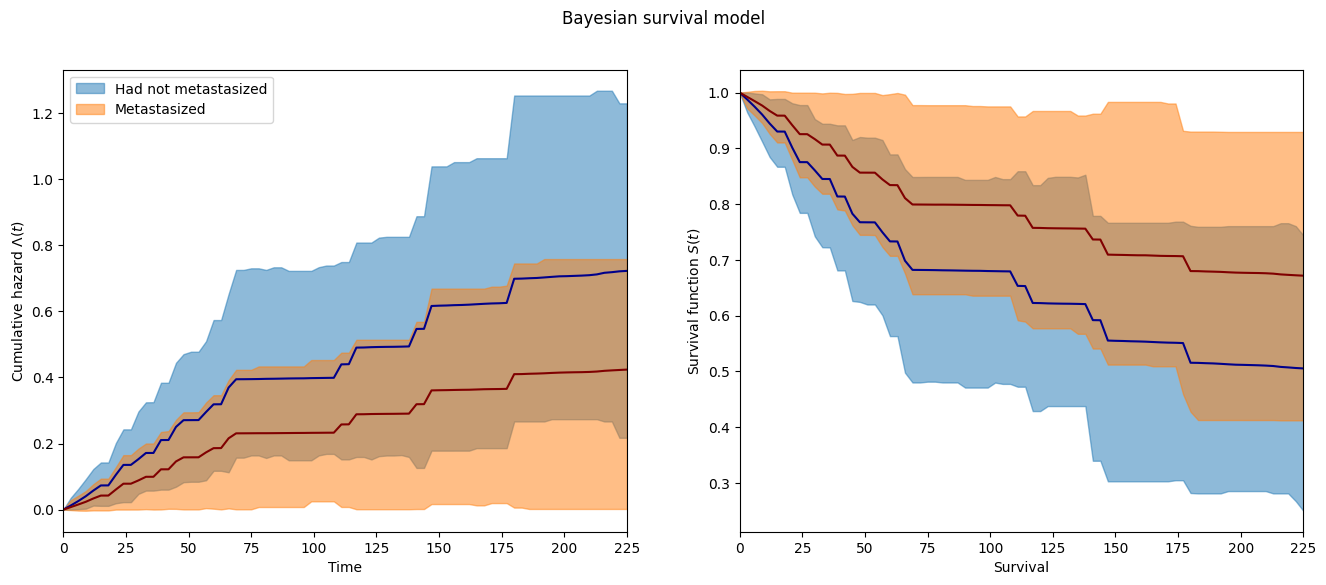

In [2]:
from main import *
# Setup device------------------------------------------------
m = bi(platform='cpu')

# Import Data & Data Manipulation ------------------------------------------------
m.data('data/mastectomy.csv', sep=',') # Import

m.df.metastasized = (m.df.metastasized == "yes").astype(np.int64)
m.df.event = jnp.array(m.df.event.values, dtype=jnp.int32)
m.surv_object(time='time', event='event', cov='metastasized', interval_length=3)
#m.plot_censoring(cov='metastasized')


def model(intervals, death, metastasized, exposure):
    # Parameters priors distributions-------------------------
    ## Base hazard distribution
    lambda0 = bi.dist.gamma(0.01, 0.01, shape= intervals.shape, name = 'lambda0')
    ## Covariate effect distribution
    beta = bi.dist.normal(0, 1000, shape = (1,),  name='beta')
    ## Likelihood
    ### Compute hazard rate based on covariate effect
    #lambda_ = numpyro.deterministic('lambda_', jnp.outer(jnp.exp(beta * metastasized), lambda0)) 
    lambda_ = m.hazard_rate(cov = metastasized, beta = beta, lambda0 = lambda0)
    ### Compute exposure rates
    mu = numpyro.deterministic('mu', exposure * lambda_)

    # Likelihood calculation
    y = lk('obs', Poisson(mu + jnp.finfo(mu.dtype).tiny), obs = death)

m.run(model, num_samples=500) 

print(m.summary())
m.plot_surv()

In [10]:
m.posteriors['lambda0'].shape

(500, 76)

In [14]:
m.posteriors['beta'][:,0].shape

(500,)

In [24]:
jnp.exp(self.posteriors['beta']).shape

(500, 1)

In [29]:
array_expanded.shape

(1, 500)

In [30]:
self.posteriors['lambda0'].shape

(500, 76)

In [28]:
self = m
base_hazard = self.posteriors['lambda0']
array_expanded = jnp.expand_dims(jnp.exp(self.posteriors['beta'][:, 0]), axis = 0)
met_hazard =self.posteriors['lambda0'] * array_expanded
met_hazard.shape

TypeError: mul got incompatible shapes for broadcasting: (500, 76), (1, 500).

In [47]:
self.posteriors['beta'][:, 0] .shape

(500,)

In [24]:
base_hazard = m.posteriors['lambda0']
array_expanded = jnp.expand_dims(np.exp(m.posteriors['beta'][:,0]), axis=1)
met_hazard =m.posteriors['lambda0'] * array_expanded
self = m
fig, (hazard_ax, surv_ax) = plt.subplots(ncols=2, sharex=True, sharey=False, figsize=(16, 6))   

az.plot_hdi(
    self.interval_bounds[:-1],
    self.cum_hazard(base_hazard),
    ax=hazard_ax,
    smooth=False,
    color="C0",
    fill_kwargs={"label": "Had not metastasized"},
)

az.plot_hdi(
    self.interval_bounds[:-1],
    self.cum_hazard(met_hazard),
    ax=hazard_ax,
    smooth=False,
    color="C1",
    fill_kwargs={"label": "Metastasized"},
)   
hazard_ax.plot(self.interval_bounds[:-1], jnp.mean(self.cum_hazard(base_hazard), axis = 0), color="darkblue")
hazard_ax.plot(self.interval_bounds[:-1], jnp.mean(self.cum_hazard(met_hazard), axis = 0), color="maroon")   
hazard_ax.set_xlim(0, self.time.max())
hazard_ax.set_xlabel(xlab)
hazard_ax.set_ylabel(r"Cumulative hazard $\Lambda(t)$")
hazard_ax.legend(loc=2) 
az.plot_hdi(self.interval_bounds[:-1], self.survival(base_hazard), ax=surv_ax, smooth=False, color="C0")
az.plot_hdi(self.interval_bounds[:-1], self.survival(met_hazard), ax=surv_ax, smooth=False, color="C1")  
surv_ax.plot(self.interval_bounds[:-1], jnp.mean(self.survival(base_hazard), axis = 0), color="darkblue")
surv_ax.plot(self.interval_bounds[:-1], jnp.mean(self.survival(met_hazard), axis = 0), color="maroon")   
surv_ax.set_xlim(0, self.time.max())
surv_ax.set_xlabel(ylab)
surv_ax.set_ylabel("Survival function $S(t)$")  


TypeError: mul got incompatible shapes for broadcasting: (500, 76), (1, 500).

/home/sosa/.local/lib/python3.10/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)


ValueError: x and y must have same first dimension, but have shapes (76,) and (500, 76)

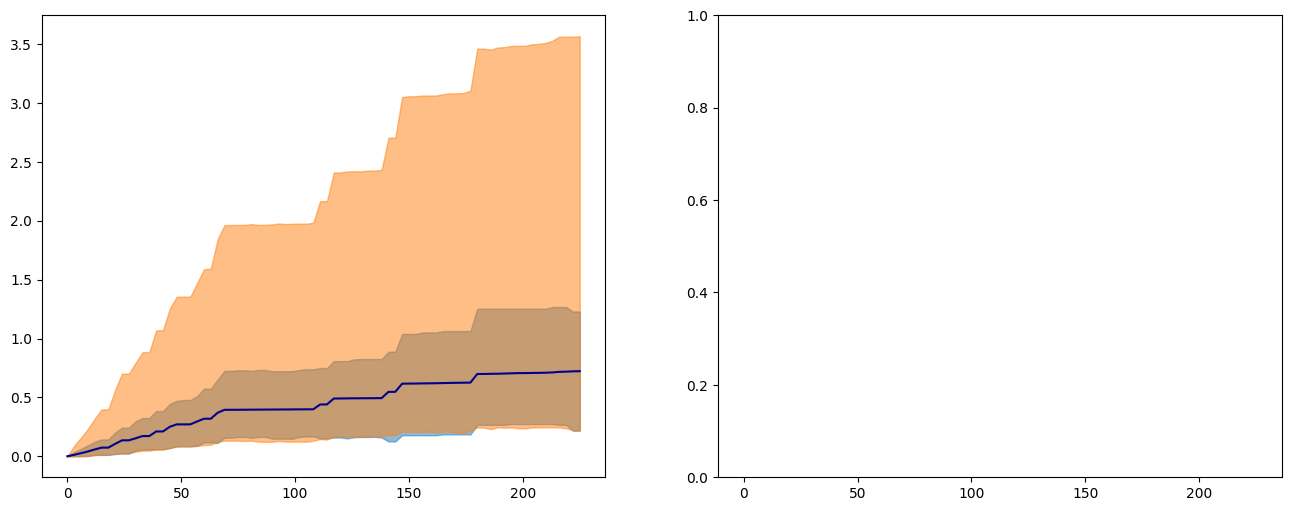

In [8]:
m.plot_surv()

In [12]:
beta = bi.dist.normal(0, 1000, name='beta', sample=True)
beta.shape

()

In [7]:
beta = bi.dist.normal(0, 1000, name='beta', sample=True, shape=(1,))
lambda0 = bi.dist.gamma(0.01, 0.01, shape= m.data_on_model['intervals'].shape, name = 'lambda0', sample=True)

lambda_ = jnp.outer(jnp.exp(beta @ m.data_on_model['metastasized']), lambda0)
lambda_.shape

(44, 76)

In [30]:
m.df.loc[:, 'time'].values

AttributeError: 'bi' object has no attribute 'df'

In [ ]:

def model(intervals, death, metastasized, exposure):
    # Parameters priors distributions-------------------------
    ## Base hazard distribution
    lambda0 = bi.dist.gamma(0.01, 0.01, shape= intervals.shape, name = 'lambda0')
    ## Covariate effect distribution
    beta = bi.dist.normal(0, 1000, name='beta')
    ## Likelihood
    ### Compute hazard rate based on covariate effect
    lambda_ = numpyro.deterministic('lambda_', jnp.outer(jnp.exp(beta @ metastasized), lambda0)) 
    ### Compute exposure rates
    mu = numpyro.deterministic('mu', exposure * lambda_)

    # Likelihood calculation
    y = lk('obs', Poisson(mu + jnp.finfo(mu.dtype).tiny), obs = death)

m.run(model, num_samples=500) 

print(m.summary())

m.plot_surv()

In [26]:
import pandas as pd
from main import *

df = pd.read_csv("data/mastectomy.csv")
df.metastasized = (df.metastasized == "yes").astype(np.int64)
m = bi()

m.to_discrete_time(df)


jax.local_device_count 32


In [27]:
m.intervals

array([0])

In [ ]:

m.data_on_model = {}
m.data_on_model['intervals'] = jnp.array(intervals)
m.data_on_model['death'] = jnp.array(death)
m.data_on_model['metastasized'] = jnp.array(df.metastasized.values)

In [2]:
def model(intervals, death, metastasized):
    lambda0 = bi.dist.gamma(0.01, 0.01, shape= intervals.shape, name = 'lambda0')
    beta = bi.dist.normal(0, 1000, name='beta')

    lambda_ = numpyro.deterministic('lambda_', jnp.outer(jnp.exp(beta * metastasized), lambda0))
    mu = numpyro.deterministic('mu', exposure * lambda_)
    y = lk('obs', Poisson(mu + jnp.finfo(mu.dtype).tiny), obs = death)

m.run(model, num_samples=500) 
m.summary()

sample: 100%|██████████| 1000/1000 [00:11<00:00, 86.32it/s, 511 steps of size 5.37e-03. acc. prob=0.96] 


,mean,sd,hdi_5.5%,hdi_94.5%
beta,0.75,0.43,0.08,1.40
lambda0[0],0.00,0.00,0.00,0.00
lambda0[1],0.00,0.00,0.00,0.01
lambda0[2],0.00,0.01,0.00,0.01
lambda0[3],0.00,0.01,0.00,0.01
...,...,...,...,...
"mu[43, 71]",0.00,0.05,0.00,0.00
"mu[43, 72]",0.01,0.12,0.00,0.00
"mu[43, 73]",0.01,0.05,0.00,0.00
"mu[43, 74]",0.01,0.05,0.00,0.00


/home/sosa/.local/lib/python3.10/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/sosa/.local/lib/python3.10/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/sosa/.local/lib/python3.10/site-packages/arviz/plots/hdiplot.py:160: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  hdi_data = hdi(y, hdi_prob=hdi_prob, circular=circular, multimodal=False, **hdi_kwargs)
/home/sosa/.local/lib/python3.1

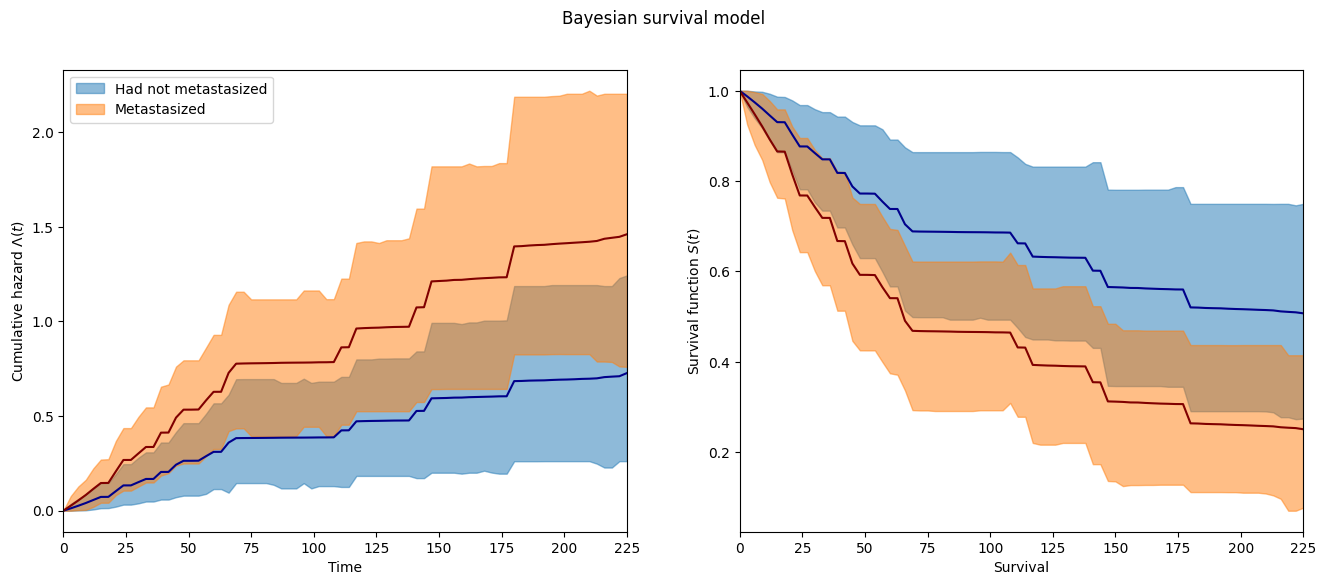

In [3]:
m.plot_surv()